# **MONTE CARLO METHODS AND FINITE-SIZE ANALYSIS IN PARAMAGNETIC-FERROMAGNETIC MODELS OF PHASE TRANSITION**

Authors:
* Carlo Divari
* Gloria Isotton
* Maryam Feizi
* Sara Munafò

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import pandas as pd
import PIL.Image
from numba import jit, prange
from scipy.optimize import curve_fit

# **INTRODUCTION**

The purpose of this work is to present a numerical study of the second-order phase transition in the 2D Ising model. 
Energy, magnetization, specific heat and magnetic susceptibility are computed with a special focus on their behaviour around the critical temperature.
In particular, critical exponents and the critical temperature are estimated by using computational methods such as nonlinear fits and finite-size scaling techniques. 
In order to do so, Monte Carlo simulations are performed for different lattice sizes with periodic boundary conditions.


## Ising model

In the standard assumptions, particles with a certain spin (up or down) are
located on the N nodes of a lattice (sites) and interact with their nearest neighbours, i.e. those particles with whom they share an edge (bond). For
simplicity, spin up is identified with a value $s_{i} = +1$, spin down is $s_{i} = -1$
(spins are measured in units of $\hbar/2$). The Hamiltonian of a given configuration
S is given by:

$$H(S)= -\sum_{< ij> } J_{ij}s_{i}s_{j} - h \sum_{i} s_{i}$$

The first term is a summation over all pairs of interacting spins; if the
behaviour of the material is ferromagnetic, $J_{ij} > 0$ and concordant spins
give a negative contribution to the Hamiltonian. 
The second term depends on the external magnetic field $h$, in this project we will consider $h=0$.
If we don't consider this second term, the Hamiltonian has $\mathbb{Z}_{2}$ symmetry, and spontaneous magnetization cannot arise. In this case, the magnetization is given by:

$${M}= \frac{1}{N} \sum_{i=1}^{N}s_{i}=0$$

With $N$ being the amount of sites (for square lattice one simply replaces $N=L^{2}$ where $L$ is the lattice length).     

Even if one does not consider this term, however, two remarkable facts arise: 
- as the number of sites $N \rightarrow \infty$ (thermodynamic limit) there is spontaneous symmetry breaking; 
- if the temperature is above $T_{C}$ the behaviour of the model is paramagnetic and no symmetry breaking occurs.

In the analysis of the system, we also focused on the behaviour of the specific heat $C_H$ and the susceptibility $\chi_T$. 
One can show that these quantities can be expressed in terms of fluctuations of the extensive variables: 
$$C_H=\left(\frac{\partial E}{\partial T}\right)_{H}=\frac{1}{k_B T^2}(\langle E^{2} \rangle - \langle E \rangle^{2})$$

$$\chi_T=\left(\frac{\partial M}{\partial H}\right)_{T}=\frac{1}{k_B T}(\langle M^{2} \rangle - \langle M \rangle^{2})$$

## Phase transition and critical exponents

Second order phase transitions are transitions where the second order derivatives of the thermodynamic potential (Gibbs potential), which in a magnetic system are given by the susceptibility and specific heat, present singularities.
In ferromagnetic systems, this happens around the critical temperature (also called the Curie point), which separates the paramagnetic phase from the ferromagnetic one. That means that below the Curie temperature, the system presents spontaneous magnetization in absence of an external magnetic field, whereas above it, the system is not magnetized and only responds when an external magnetic field is applied.    
It is our goal to illustrate what happens in second-order transitions and how do the thermodynamic properties of the systems behave.

Near the critical temperature $T_{c}$, several physical properties obey a power
law dependence on $\mid T-T_{c}\mid$, characterized by the so called critical exponents.    

These exponents describe the behaviour of observables during continuous phase transitions near a critical
temperature $T_{c}$.
For a magnetic system, magnetic susceptibility per site and the specific heat per site follow the power laws:
$$\chi_T \sim \mid 1- \frac{T}{T_{c}} \mid ^{-\gamma}$$

$$C_{H}\sim \mid 1-\frac{T}{T_{c}}\mid^{-\alpha}$$
$\alpha$ and $\gamma$ are the critical exponents.

The exponent $\beta$, is the easiest to conceptualise.
$\beta$ is associated to the order parameter of the system, which in a magnetic system is the magnetisation. Thus, what $\beta$ describes is the behaviour when the system spontaneously magnetises. Assuming no
external magnetic field and for $T<T_c$:
$$M \sim \mid 1- \frac{T}{T_{c}}\mid ^{\beta}$$

Here we list the critical exponents associated with their respective physical observables, when $h=0$ for the 2D Ising Model:

In [2]:
col_index = ["Critical Exponent", "2D Ising Model"]
row_index = ["Specific Heat", "Magnetization", "Susceptibility","Correlation Length"]
values = [["$\u03B1$","0"],["$\u03B2$","1/8"],["$\gamma$","7/4"],["$\nu$",1]]
data = pd.DataFrame(values, columns=col_index, index=row_index)
data 

,Critical Exponent,2D Ising Model
Specific Heat,$α$,0
Magnetization,$β$,1/8
Susceptibility,$\gamma$,7/4
Correlation Length,$\nu$,1


# **SIMULATION OF A 2D ISING MODEL**

The system is generated as a $L×L$ square lattice and in every site of the lattice a spin is set with equal probability of being $\pm 1$. 
For reliable Monte-Carlo simulations, we need a good random number generator. We choose Python’s numpy.random.randint to select the site to be flipped at each motecarlo step. It uses the Mersenne twister pseudo-random number generator and we expect to get a uniform random distribution. 
After testing that, we created one function to calculate the energy, one for the delta energy between two states and another one for the magnetization.

In [3]:
#Create a NxN lattice with random spin configuration
@jit(nopython=True)
def init_lattice(N):
    '''
    Return a random spin configuration in a 2d square lattice
    '''
    return np.random.choice(np.array([-1,1]),size=(N,N))

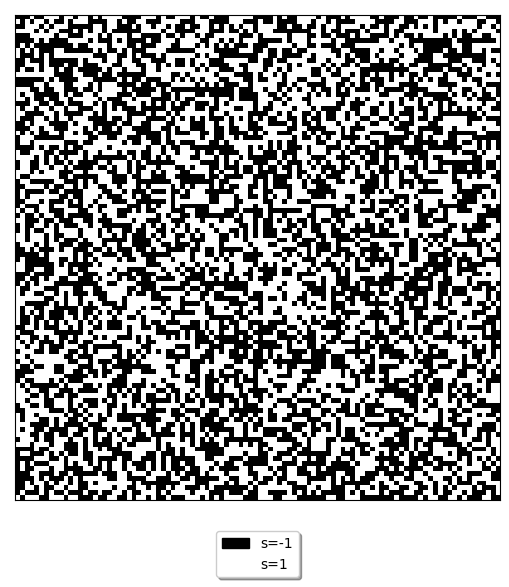

In [4]:
import matplotlib.patches as mpatches
try_state = init_lattice(100)
fig, ax = plt.subplots(figsize=(7,7), layout='constrained')       
im = ax.matshow(try_state, cmap = plt.cm.cubehelix) 
ax.set_xticks([])
ax.set_yticks([])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend below current axis
b_patch = mpatches.Patch(color='black', label='s=-1')
w_patch = mpatches.Patch(color='white', label='s=1')
ax.legend(loc='upper center', handles=[b_patch,w_patch], bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True)
plt.show()

In [5]:
#Let's define some useful functions
@jit(nopython=True)
def energy(state):
    
    '''define the energy at a given configuration'''
    
    N = state.shape[0]
    energy = 0
  
    for i in range(N):
        for j in range(N):

      # get nearest neighbours states
            nn = state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N]
            energy +=  -state[i,j] * nn
    return energy / 2     #to avoid counting twice the same neigbours while moving across the lattice
    
@jit(nopython=True)    
def magnetization(state):
    
    '''define the magnetization per site'''
    
    Magn = np.sum(state)    
    return Magn

@jit(nopython=True)
def delta(s,a,b):
    L= int(s.shape[0])
    
    '''define delta E between 2 spin configurations'''

    return 2*s[a,b]*(s[a,(b+1)%L]+s[a,(b-1)%L]+s[(a+1)%L,b]+s[(a-1)%L,b])   #consider only nearest neighbours


## Metropolis-Hastings algorithm

Monte Carlo simulations of the Ising model are performed through the
Metropolis Algorithm (MA). The algorithm belongs to a more general class of algorithms,
Monte Carlo Markov Chains (MCMCs), which are used when the
probability distribution of the Monte Carlo inputs is unknown. 
The idea of MCMCs is to make use of a Markov Chain, which is an evolution in time that is not determinist, but follows a transition probability from the current state to a new state. A Markov chain satisfies that the probability distribution of the next state depends only on the current state.

 

In order to simulate the behaviour of this model, we need to compute the transition probability $W(s \rightarrow s')$. This can be written as the product of the selection probability $g$ and the acceptance probability $A$:
$$ W(s \rightarrow s') = g(s \rightarrow s')\cdot A(s \rightarrow s') $$
- For the former, following the Glauber dynamics, we chose to implement a Monte Carlo algorithm based on local moves. In this case the selection probability is clearly uniform:
$$g(s \rightarrow s') = 1/N^2$$
- For the second one we set that te acceptance probability must respect the Metropolis-Hasting rule:
<br>
$$ A(s \rightarrow s') = 
\begin{cases} 
e^{ - \beta ( E_{s'} - E_{s} ) } \ \ \ \ \ if \ E_{s'} - E_{s}>0
\\
1 \hspace{2.5cm} otherwise
\end{cases} $$


Thanks to the Single-Flip dynamics is possibile to simplify further, in fact:
<br>
$$ \Delta E = E_{s'} - E_{s} = -(s_i' - s_i) \sum_{j \in n.n.(i)} s_j = 2 s_i \sum_{j \in n.n.(i)} s_j$$



If $E_{s'}<E_s$ ( meaning $H(s^{\prime}) < H(s)$) the new configuration is accepted with certainty: this
is a step towards the equilibrium state (which is just the most likely in
statistical mechanics). If $H(s^{\prime}) > H(s)$ the new configuration may be
accepted: this should prevent the system to get stuck in local minima. The
key term in previous is $\beta$: if $\beta$ is high, $T$ is low and it is less likely that higher energy configurations will be accepted; if $\beta$ is low, $T$ is high (there is a lot
of noise) and almost any new configuration is accepted. Intuitively, in the
first case the system will rush towards the equilibrium state; in the latter
case it will just "wander around" the phase space.

In the case of the 2D Ising lattice, this translates to the following procedure:
- Choosing randomly one site (i,j) in the lattice, we computed the energy difference $\Delta E$ between the actual energy and the energy if the spin is flipped.
- If $\Delta E < 0$,  the new configuration is accepted. If not, it may be accepted with probability $e^{−\beta \Delta E}$ where $\beta = \frac{1}{k_BT}$ and $k_B$ is the Boltzmann constant.

Energy and magnetization of the system are saved; they are then averaged and observables calculated.

Before presenting the code, it is necessary to underline that in the function 'mc_step' we perform a single Monte Carlo step consisting of $L^2$ spin flip attempts while in the function 'Ising_mc' we simulate multiple times (namely 'realiz' times) the sistem for a long time ( $10^4$ Monte Carlo steps) and then we average the obtained trajectories.
The number of Monte Carlo steps and realizations to produce a good sampling depends on the temperature at which the system is. Nevertheless, if while computing observables, such as energy and magnetization, the curves are noisy, then it is necessary to perform more MC steps.    

In [6]:
# Define Monte Carlo function
@jit(nopython=True)
def mc_step(s,temp):
    
    L = int(s.shape[0])
    for i in prange(int(L*L)):
        
        # choose a random spin on the grid
        a, b = np.random.randint(0,L), np.random.randint(0,L)
        
        # compute the delta energy before and after the flip of s(a,b)
        delta_E = delta(s,a,b)  

        # metropolis test and spin-flip
        if delta_E <= 0 or np.random.uniform(0, 1) < np.exp(-delta_E/temp):
            s[a,b]*=-1
    return s

In [7]:
# Define Ising model dynamics
@jit(nopython=True)
def Ising_mc(L,T,time_f,realiz):
    magnetizations=np.zeros(time_f)
    energies=np.zeros(time_f)
        
    for r in range(0,realiz):
        s = np.ones((L,L))
            
        for t in range(0,time_f):
            m = magnetization(s)
            magnetizations[t] = magnetizations[t]+m/realiz
            energies[t] = energies[t]+energy(s)/realiz
            s = mc_step(s, T)
            
        E = np.mean(energies)
        M = np.mean(magnetizations)                
        C = (np.std(energies)**2)/(T**2)
        Chi = (np.std(magnetizations)**2)/(T)
    
    return (E,M,C,Chi)

## Testing the model

Before starting with the analysis of the phase transition we check if the model behaves as expected, testing the outputs for different inputs.
Here we plot the energy and the magnetisation during the equilibration for some values of temperature. 
As one can see form the following figure, is clear that for $T < T_c$ and $T > T_c$ the behavior of the system is relatively simple. In the ferromagnetic phase the magnetization settles around a value $M ≠ 0$, while in the paramagnetic phase the order parameter settles around $M = 0$. But near the transition $T ≈ T_c$ , the system behaves exotically, the fluctuations in the order parameter are huge, M does not settle around a concrete value, but covers a broad range of values.

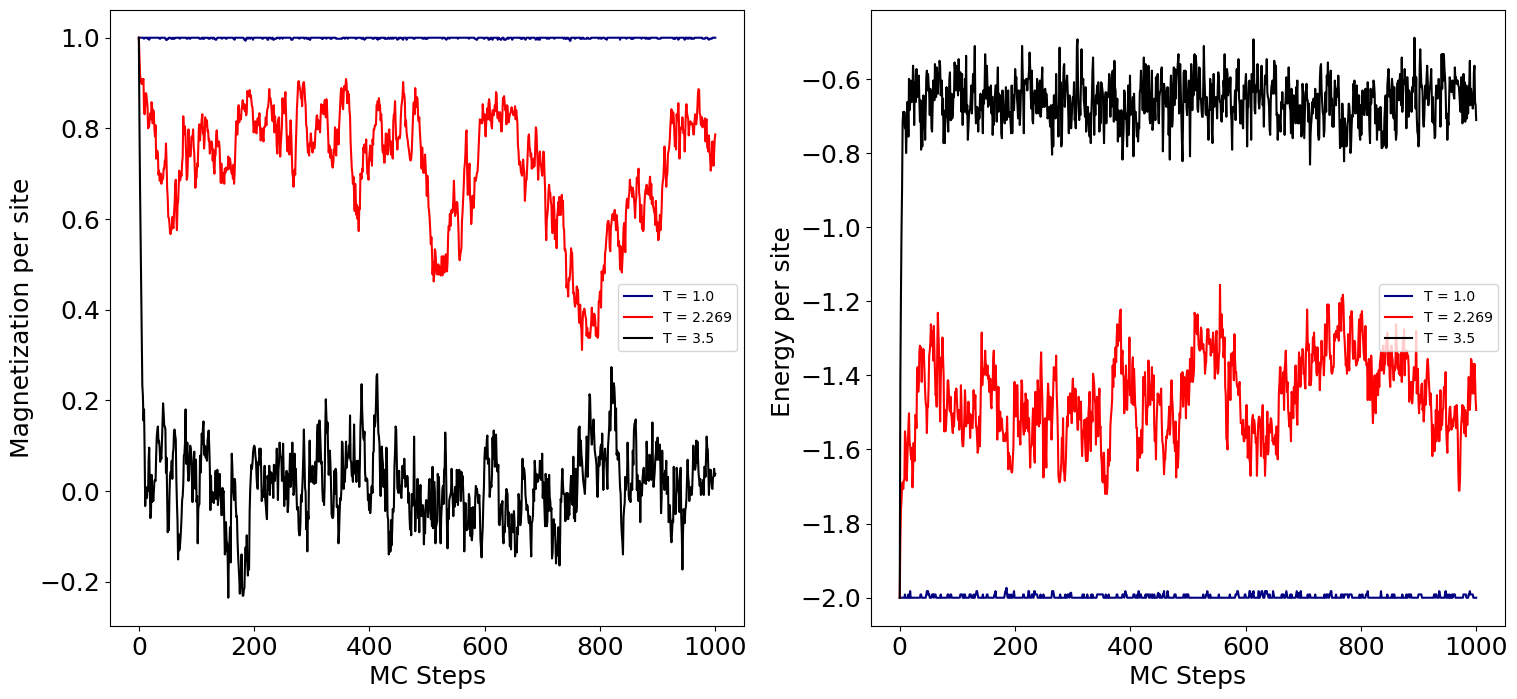

In [8]:
T_c = 2/np.log(1 + np.sqrt(2))  #known value from Onsager
time_f= int(1e3)   
realiz=1
l=30
temperatures = [1.0, 2.269, 3.5]
mc_steps=np.linspace(0,time_f,time_f)
col_map = np.array(["navy", "red", "black"])
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 8))
color_count=0

for T in temperatures:
    magnetizations=np.zeros(time_f)
    energies=np.zeros(time_f)
        
    for r in range(0,realiz):
        s = np.ones((l,l))

        for t in range(0,time_f):
            m = magnetization(s)
            magnetizations[t] = magnetizations[t]+m/realiz
            energies[t] = energies[t]+energy(s)/realiz
            s = mc_step(s, T)
              
    ax1.plot(mc_steps, magnetizations/(l**2), label = 'T = {0}'.format(T), c =col_map[color_count] )
    ax1.legend(loc = 'best')
    ax2.plot(mc_steps, energies/(l**2), label = 'T = {0}'.format(T),c =col_map[color_count])
    ax2.legend(loc = 'center right')
    ax1.set_xlabel("MC Steps", fontsize = 18)
    ax2.set_xlabel("MC Steps", fontsize = 18)
    ax1.set_ylabel("Magnetization per site", fontsize = 18)
    ax2.set_ylabel("Energy per site ", fontsize = 18)
    ax1.tick_params(axis="x",labelsize=18)
    ax2.tick_params(axis="x",labelsize=18)
    ax1.tick_params(axis="y",labelsize=18)
    ax2.tick_params(axis="y",labelsize=18)
    color_count+=1
plt.show()

Another test we can run in order to see if the simulated system behaves as expected is to simulate a ground state (all spins up) and to see if it reach the same equilibrium state of a random one, setting the temperature to $T=3.5$ for example.

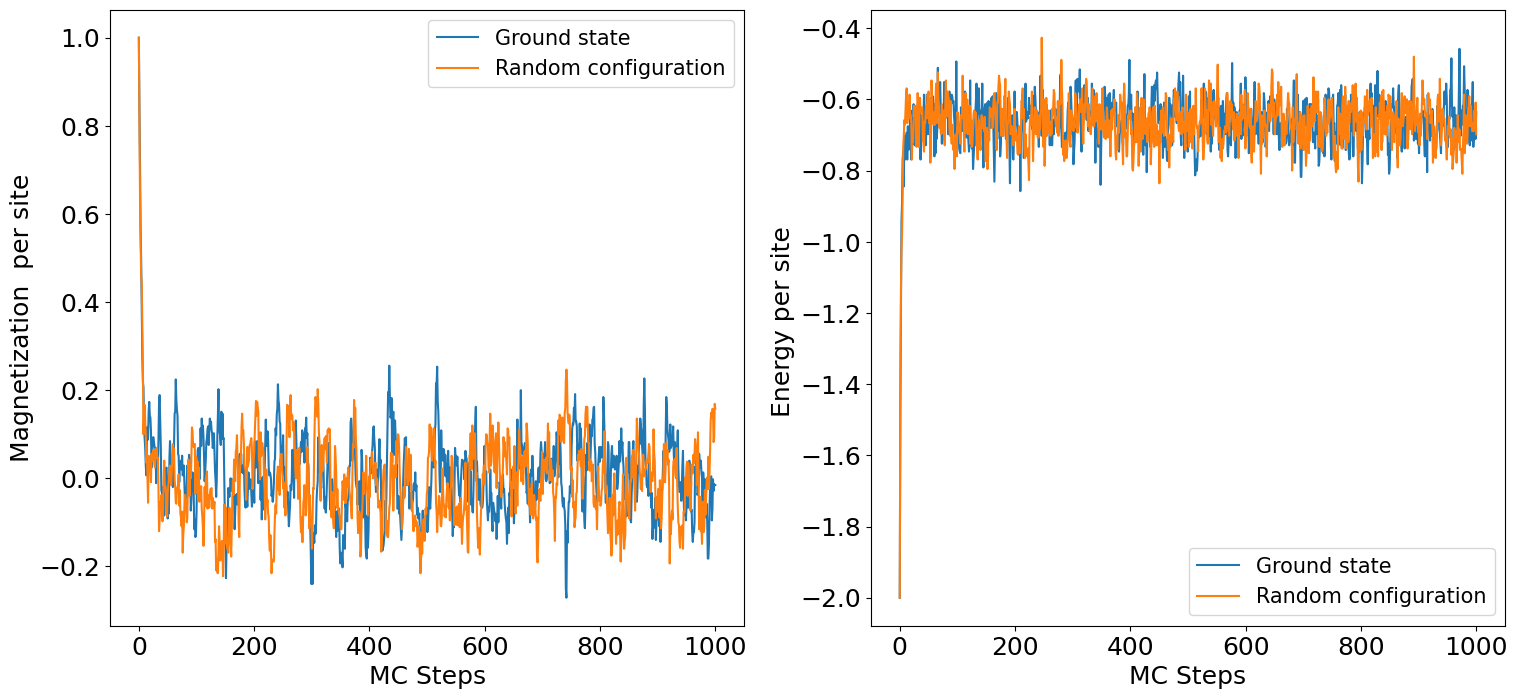

In [9]:
T_c = 2/np.log(1 + np.sqrt(2))  #known value from Onsager
time_f= int(1e3)   
realiz=1
l=30
T=3.5
order = [0,1]
labels = ["Ground state","Random configuration"]
mc_steps=np.linspace(0,time_f,time_f)
col_map = np.array(["navy", "red", "black"])
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 8))
count=0

for r in order:
    magnetizations=np.zeros(time_f)
    energies=np.zeros(time_f)
        
    for r in range(0,realiz):
        if r==0: s = np.ones((l,l)) #Ground state 
        if r==1: s= init_lattice(l) #Random configuration
            
        for t in range(0,time_f):
            m = magnetization(s)
            magnetizations[t] = magnetizations[t]+m/realiz
            energies[t] = energies[t]+energy(s)/realiz
            s = mc_step(s, T)
              
    ax1.plot(mc_steps, magnetizations/(l**2), label = str(labels[count]))
    ax2.plot(mc_steps, energies/(l**2), label = str(labels[count]))
    ax1.set_xlabel("MC Steps", fontsize = 18)
    ax2.set_xlabel("MC Steps", fontsize = 18)
    ax1.set_ylabel("Magnetization  per site", fontsize = 18)
    ax2.set_ylabel("Energy per site ", fontsize = 18)
    ax1.tick_params(axis="x",labelsize=18)
    ax2.tick_params(axis="x",labelsize=18)
    ax1.tick_params(axis="y",labelsize=18)
    ax2.tick_params(axis="y",labelsize=18)
    ax1.legend(fontsize = 15, loc=0)
    ax2.legend(fontsize = 15, loc=0)
    count+=1
plt.show()

As we can see, there are no significant differences. For our code, we chose to initialize the system to the ground-state, with all spins up ($s[i,j]=+1$   $\forall i,j$).

In [10]:
from ipywidgets import interact

In [11]:
import ipywidgets as widgets

In [36]:
def display_lattice_spin(lattice,temp):
    plt.figure()
    plt.imshow(np.uint8(lattice+1)*0.5, cmap='gray')
    plt.gca().add_patch(plt.Rectangle((0,0),1,1,fc='white',ec='black', lw=2))
    plt.gca().add_patch(plt.Rectangle((0,1),1,1,fc='black',ec='black', lw=2))
    plt.gca().set_title('T='+str(temp)+' J/Kb')
    plt.legend(['s=1', 's=-1'], loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()


In [88]:
def display_ising_sequence(images,step,temp):
    frame_label = widgets.Label(value='Frame: 0')
    def show_sequence(frame=widgets.Play(min=0,max=step)):
        frame_label.value = 'Step: {}'.format(frame)
        return display_lattice_spin(images[frame],temp)
    interact(show_sequence)
    hbox = widgets.HBox([frame_label],justify_content='flex-end')
    display(hbox)

In [89]:
step=50
images=[init_lattice(500)]
temp=0.6
for i in range(step):
    images.append(mc_step(images[-1].copy(),temp=0.6))

Evoution of 50 steps of the initial lattice

In [90]:
display_ising_sequence(images,step,temp)

interactive(children=(Play(value=0, description='frame', max=50), Output()), _dom_classes=('widget-interact',)…

# Simulation

In [16]:
L_val=[8,16,50,70,80,100,128]
nl = int(len(L_val))
time_f = int(1e4)    
realiz = 60    
nt = 80 
E_sim,M_sim,C_sim,Chi_sim = np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt))
Te = np.linspace(0.5,3.8,nt)
for il,L in enumerate(L_val):
    print('Simulating N={}'.format(L))
    for it,T in enumerate(Te):
        E,M,C,Chi = Ising_mc(L,T,time_f,realiz)
        E_sim[il,it] = E
        M_sim[il,it] = M
        C_sim[il,it] = C
        Chi_sim[il,it] = Chi

Simulating N=8
Simulating N=16
Simulating N=50
Simulating N=70
Simulating N=80
Simulating N=100
Simulating N=128


# Plots

In [7]:
#import all the data of simulations
L_val=[8,16,50,70,80,100,128]
nt = 80
Te = np.linspace(0.5,3.8,nt)
data = np.loadtxt('Chi_tot.txt')
Chi_tot = np.array(data)
data = np.loadtxt('specific_heat_tot.txt')
C_tot = np.array(data)
data = np.loadtxt('magnetization_tot.txt')
M_tot = np.array(data)
data = np.loadtxt('energy_tot.txt')
E_tot = np.array(data)

In the following figure, magnetization per site $M$, energy per site $E$, magnetic susceptibility per site $χ$, and specific heat per site $C$ as functions of the temperature $T$ are presented. This plots were constructed by performing
$10.000$ Monte Carlo steps per lattice size $L$. All simulations were performed considering $k_B = 1$ and $J = 1$.

Notice that because magnetization, energy, specific heat and magnetic susceptibility are extensive variables, intensive ones were constructed by dividing them by the number of sites in the lattice $N = L^2$ .

In [30]:
def plot_values (E,M,C,Chi,L_val):
    titles = ['Energy per site','Magnetisation per site','Specific Heat per site','Susceptibility per site']
    #labels = ['e', 'm', 'c', 'chi']
    physical_quantities = [E,np.abs(M),C,Chi]
    plt.figure(figsize = (17,14))
    for i in range(len(physical_quantities)):
        ax = plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        #ax.set_title(titles[i], fontsize = 20, fontweight = "bold" )
        ax.grid('--', alpha= 0.7)
        for j in [0,2,4,6]:
            ax.plot(Te, physical_quantities[i][j] / L_val[j]**2, '.',markersize=9, label='N='+str(L_val[j]), alpha=0.7)
            
            ax.legend()
    plt.savefig('im.png')       
    plt.subplots_adjust(hspace=0.8)

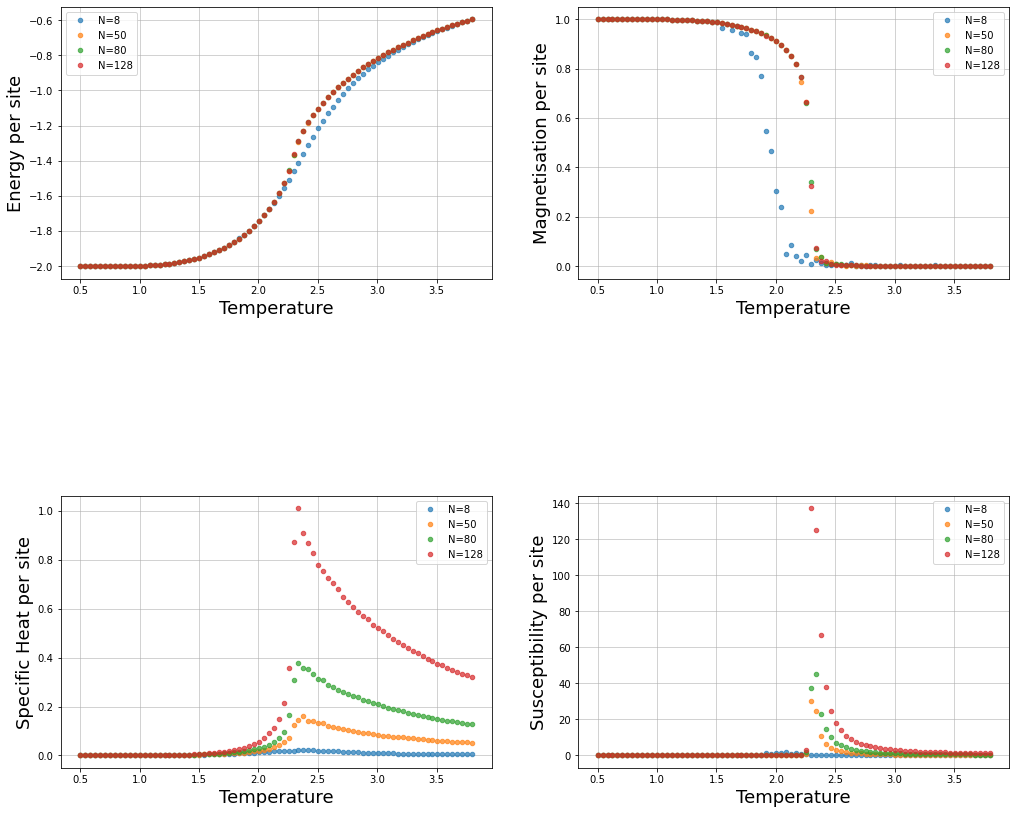

In [31]:
plot_values(E_tot,M_tot,C_tot,Chi_tot,L_val)

# **Critical exponent estimation**

## Exponent $\gamma$

In the termodinamic limit $N\rightarrow \infty$, we know that $\chi \sim |T-T_c|^{-\gamma}$. We try to estimate $\gamma$ as N increases. As we said, the expected value for 2D Ising is $\gamma=7/4 \sim 1.75$.

A simulation with  different values of L from 8 up to 128 was performed, considering a relativly high number of realizations over Monte Carlo steps ($realiz=60$) and $10^4$ Monte Carlo steps. We simulated the system for 80 values of temperature in the interval $[0.5,3.8]$ in unit of $k_B$ and we calculated the corresponding observables.

We then selected 40 values on the right of the expected Onsager value for Tc  and performed a nonlinear fit of the magnetic susceptibility per site  $\chi$. In order to get better results we set one free parameter, meanly  we extimate only $\gamma$ and we used the Python's optimize.curve_fit function.

48
53
50
44
45
44
44


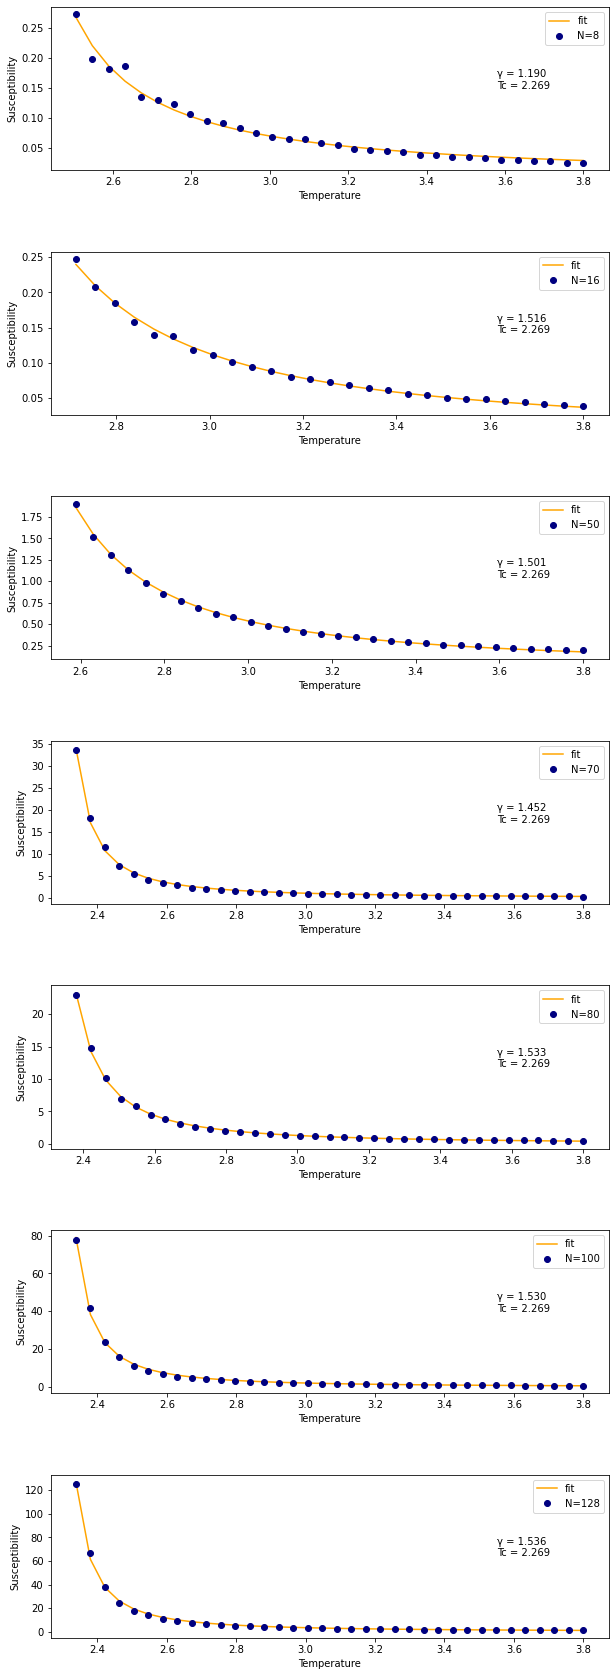

In [33]:
from scipy import optimize

T_c = 2.269     #known value from Onsager
tt = [10, 12, 7,1,1,0,1]

def powerlaw(T, k=1, gamma=1.75):
    return k*(np.abs(T-T_c))**(-gamma)

ks, gammas, = np.zeros((len(L_val))),np.zeros((len(L_val)))
fig, axs = plt.subplots(nrows=len(L_val), ncols=1, figsize=(10, 30))
fig.subplots_adjust(hspace = .5, wspace=.01)
axs = axs.ravel()

for i in range(len(L_val)):
    Tmax = np.argmax(Chi_tot[i]) +tt[i] #we start from the peak of chi, we study the decreasing exponential
    params, params_covariance = optimize.curve_fit(powerlaw, Te[Tmax:], Chi_tot[i][Tmax:]/L_val[i]**2, maxfev=int(1e9))
    ks[i] = params[0]
    gammas[i] = params[1]
    #Tcs[i] = params[2]
    print(Tmax)
    axs[i].plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[i], gammas[i]),'orange', label='fit')
    axs[i].plot(Te[Tmax:], Chi_tot[i][Tmax:]/L_val[i]**2, 'o',color="navy", label='N={}'.format(L_val[i]))
    axs[i].text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(gammas[i]),'%.3f'%T_c), transform=axs[i].transAxes)
    axs[i].set_xlabel('Temperature')
    axs[i].set_ylabel('Susceptibility')
    axs[i].legend()

fig.savefig('full_figure_gamma.png')

## Exponent $\beta$

In the termodinamic limit $N\rightarrow \infty$, we know that $M \sim |T-T_c|^{-\beta}$. We try to estimate $\beta$ as N increases. The expected value for 2D Ising model is $\beta=1/8 \sim 0.125$.
It is worth to notice the importance of considering large systems in order to obtain reliable results of the thermodynamic quantities because Onsager’s solution is in the thermodynamic limit while numerical simulations are finite. We run a simulation for $L=[70, 100, 128]$,  considering an high number of realizations over Monte Carlo steps ($realiz=100$) and $10^4$ Monte Carlo steps. We simulated the system for 80 values of temperature in the interval $[0.9·T_c,1.1·T_c]$ in unit of $k_B$ and we calculated the corresponding observables.

We selected the first $30$ points at the left of Onsager's the critical temperature and we perform a nonlinear fit using Python's nlinfit.
We feed the algorithm with some initial guess points in order to speed up the convergence.
The extimated value of $\beta$ and $T_c$ are presented below.

In [70]:
L_val=[100]
nl = int(len(L_val))
time_f = int(1e4)    
realiz = 100    
nt = 80
E_b,M_b,C_b,Chi_b = np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt))
Te = np.linspace(0.9*T_c,1.1*T_c,nt)
for il,L in enumerate(L_val):
    print('Simulating N={}'.format(L))
    for it,T in enumerate(Te):
        E,M,C,Chi = old_Ising(L,T,time_f,realiz)
        E_b[il,it] = E
        M_b[il,it] = M
        C_b[il,it] = C
        Chi_b[il,it] = Chi

Simulating N=100


T_{c} = 2.273 (95% confidence interval = 2.272 2.273])

beta = 0.121 (95% confidence interval = [0.119 0.123])


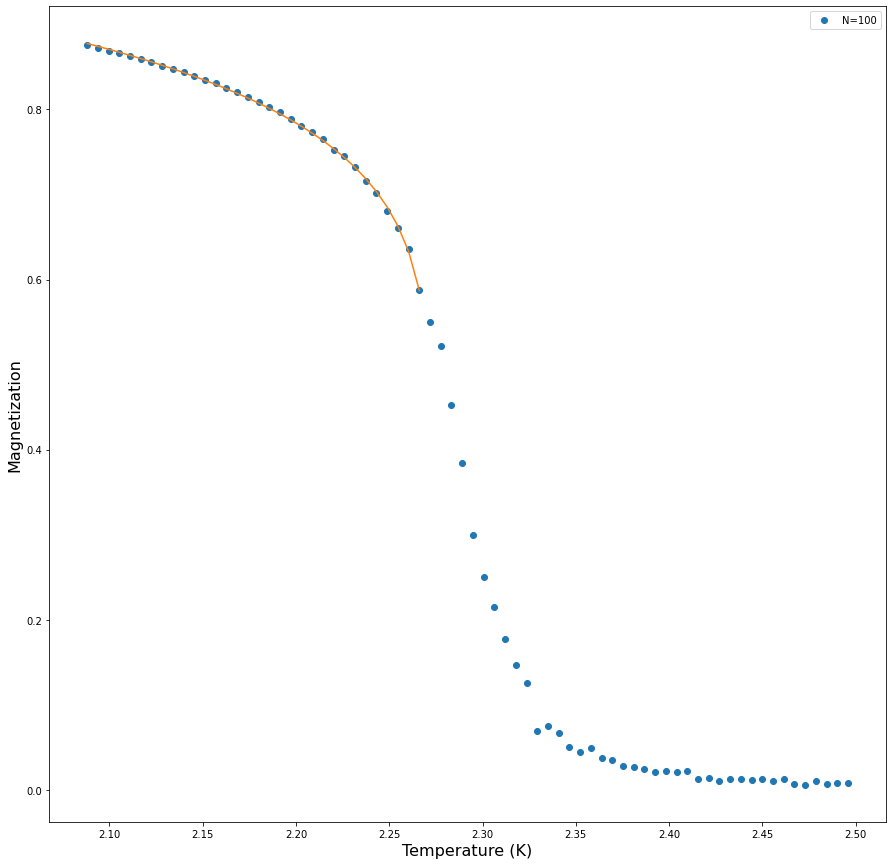

In [92]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
from pycse import nlinfit # ---> pip install pycse

T_c = 2/np.log(1 + np.sqrt(2))  #known value from Onsager

for i in range(len(L_val)):

    # Let us fit the first 45 values on the left of Onsager's Tc
    Ts2fit = Te[8:40]
    M2fit = M_b[i][8:40]/100**2

    # Function to fit to
    def M_fit(Ts, Tcinf, beta, a):
        M = a * np.abs((-Ts + Tcinf) / Tcinf) ** beta
        return M

    # Initial guess
    guess = [2.3, 0.11, 1]

    pars, pint, SE = nlinfit(M_fit, Ts2fit, M2fit, guess, alpha=0.05)
    Tcinf, beta, a = pint
    Tcinf=pars[0]
    beta=pars[1]
    a=pars[2]

    print ('T_{{c}} = {0:1.3f} (95% confidence interval = {1:1.3f} {2:1.3f}])\n'.format(pars[0], pint[0][0], pint[0][1]))
    print ('beta = {0:1.3f} (95% confidence interval = [{1:1.3f} {2:1.3f}])'.format(pars[1], pint[1][0], pint[1][1]))

    # Plotting
    Tfit = np.linspace(Ts2fit.min(), T_c)
    plt.rcParams["figure.figsize"] = (15,15)
    plt.plot(Te[8:], M_b[i][8:]/100**2, 'o', label='N=' + str(L_val[i]))
    Ts2fit = Te[8:40]
    plt.plot(Ts2fit, M_fit(Ts2fit, Tcinf, beta, a))
    plt.xlabel('Temperature (K)', fontsize=16)
    plt.ylabel('Magnetization', fontsize=16)
    plt.legend()
    plt.savefig('beta_extimation_nonlinearfit.png')
    plt.show()

In [95]:
print(M_b/100**2)

[[0.896 0.894 0.891 0.889 0.886 0.884 0.881 0.878 0.875 0.872 0.869 0.866
  0.863 0.859 0.856 0.852 0.848 0.844 0.84  0.835 0.831 0.825 0.82  0.815
  0.809 0.803 0.797 0.789 0.781 0.773 0.765 0.753 0.745 0.732 0.716 0.701
  0.68  0.661 0.636 0.588 0.55  0.521 0.453 0.384 0.299 0.251 0.215 0.178
  0.147 0.126 0.069 0.075 0.067 0.05  0.044 0.049 0.037 0.035 0.028 0.027
  0.024 0.021 0.022 0.021 0.023 0.013 0.014 0.01  0.013 0.013 0.012 0.013
  0.01  0.012 0.008 0.006 0.011 0.007 0.008 0.009]]


Results for beta:
    * N=70
    * Tc = 2.272 (95% confidence interval = 2.271 2.273])
    * beta = 0.125 (95% confidence interval = [0.119 0.130])
    
    *N=100
    *Tc = 2.273 (95% confidence interval = 2.272 2.273])
    *beta = 0.121 (95% confidence interval = [0.119 0.123])


save old data from simulations up to 80 

In [20]:
np.savetxt('energy.txt', E_old)
np.savetxt('magnetization.txt', M_old)
np.savetxt('specific_heat.txt', C_old)
np.savetxt('Chi.txt', Chi_old)

# FINITE SIZE SCALING

The basic idea of the scaling hypothesis is that the physical observables, such as the magnetization, susceptibility, and correlation function, exhibit scaling behavior near the critical point.    
To give an overview on this hypothesis, we have to introduce the correlation lenght $\xi$, which is the exponential decay rate of the two-point correlation function and measures the average distance between two spins in the lattice which are correlated.    

Near the critical temperature, which in the 2D Ising model is given by the Onsager value: $$T_c=\frac{2}{log(1+\sqrt(2))}\sim 2.26918..$$ the correlation length diverges following the power law:
$$\xi \sim \mid 1- \frac{T}{T_{c}} \mid^{-\nu}$$

For a finite system, the thermodynamics quantities, which we can indicate in general as $A$, don't show divergence near the critical temperature.    
In the scaling region ($\xi \gg L$), however, we can see traces of these divergences in the occurrence of peaks: peaks become higher and narrower and their location are shifted with respect to the location of the critical point as the system size increases. These characteristics of the peak shape as a function of temperature
are described in terms of the finite-size scaling exponents as follows:

-  The shift in the position of the maximum with respect to the critical temperature is described by:
$$T_{c}(L)-T_{c}(\infty)\propto L^{-\lambda} \qquad (1)$$
- The width of the peak scales as: 
$$\Delta T(L)\propto L^{-\Theta}$$
- The peak height grows with the system size as: 
$$A_{max}(L)\propto L^{\sigma_{max}}$$
 Defining $t= \mid 1- \frac{T}{T_{c}} \mid$, the finite-size scaling Ansatz is formulated as follows:\\
$$\frac{A_{{L}(t)}}{A_{\infty}(t)}= f[\frac{L}{\xi_{\infty}}(t)]$$    

    
Assuming that the exponent of the critical divergence of $A$ is $\sigma$, and using the fact that $\xi \sim t^{-\nu}$, the scaling ansatz is formulated as:
$$A_{L}(t)= t^{-\sigma} f[Lt^{-\nu}]$$
which can be rewritten as:
$$A_{L}(t)=L^{\sigma/\nu}\phi [L^{1/\nu}t]$$
where the scaling function $f$ is replaced by $\phi$, by extracting the factor $(Lt^{\nu})^{\sigma/\nu}$ from $f$ and writing the remaining function in terms of $(Lt^{\nu})^{1/\nu}$.    
From the last equation we can conclude that:
- The peak height scales as $L^{\sigma/\nu}$, hence $\sigma_{max}=\sigma/\nu \qquad (2)$
- The peak position scales as $L^{-1/\nu}$, hence $\lambda= 1/\nu \qquad (3)$
- The peak width also scales as $L^{-1/\nu}$, hence $\Theta=1/\nu \qquad (4)$
 
These are the finite-size scaling laws for any thermodynamic quantity which diverges at the critical point as a power law. From these laws it becomes evident that it is possible to calculate the height, position and width of the peaks as a function of the system size, the critical exponents $\nu$ and $\sigma$ can be determined.


## Exponent $\nu$ and critical temperature

In this project, we performed a finite-size scaling analysis focusing on the exponent $\nu$, based on our found values of $\chi$.    
The idea is to exploit the relation $(1)$ to estimate the critical temperature and the exponent $\nu$, which, we recall, should have value $\nu=1$.    
In order to do that we proceeded as follows:
- Found the maximum of $\chi$ for each dimension $L$; the peak of $\chi$ should, in fact, be located at the temperature $T_c(L)$;
- Performed an exponential fit in order to find $T_c(\infty)$ and the exponent $\nu$ from the following relation, derived by $(1)$ and $(3)$:$$T_c(L)=T_c(\infty)+cL^{-1/\nu}$$
  where $c$ is a constant.

In [2]:
nt = 80
Te = np.linspace(.5,3.8,nt)
T_c = 2/np.log(1+np.sqrt(2))
L_tot = np.array([8,16,50,70,80,100,128])
nl = L_tot.shape[0]

Chi = np.loadtxt("Chi_tot.txt")
print(Chi.shape)

(7, 80)


Estimated critical temperature = 2.33607

Estimated exponent nu = 0.95895



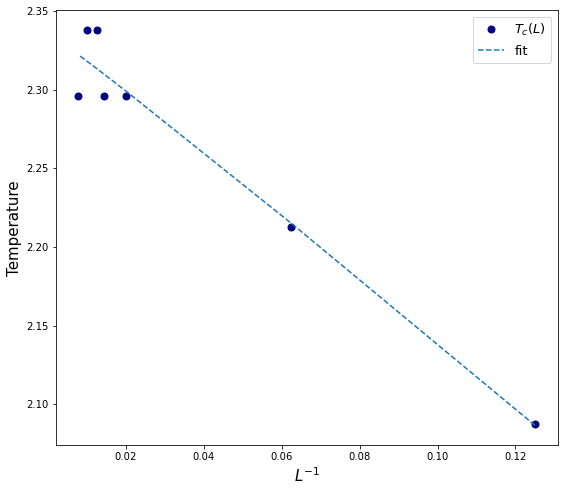

In [3]:
Chi_max = np.zeros((nl,))
T_max = np.zeros((nl,))

for i in range(nl):
    imax = np.argmax(Chi[i,:])            
    Chi_max[i] = Chi[i,imax]
    T_max[i] = Te[imax]


def Tc_fit(n,Tc_est,c,x):
    T_max = Tc_est+c*n**x
    return T_max

L_inv = np.array([1/L for L in L_tot])
guess = [0.45,0.2,1]
par, cov = curve_fit(Tc_fit,L_inv,T_max,guess,maxfev=int(1e6)) 
Tc_est = par[0]
nu = par[2]**(-1)
print('Estimated critical temperature = {0:1.5f}\n'.format(Tc_est))
print('Estimated exponent nu = {0:1.5f}\n'.format(nu))

fig, ax = plt.subplots(figsize=(9,8))
ax.plot(L_inv, T_max, 'o',markersize=7, color="navy", label="$T_{c}(L)$")
ax.plot(L_inv, Tc_fit(L_inv,par[0],par[1],par[2]), '--', label="fit")
ax.set_xlabel("$L^{-1}$", fontsize=15)
ax.set_ylabel("Temperature",fontsize=15)
ax.legend(loc="best",fontsize=13)


## Estimation of $\gamma$

We can now apply the finite-size scaling theory to one of the observables in order to make an estimation of its critical exponent $\gamma$, which known value is $\gamma=1.75$.    
We chose to focus on the susceptibility $\chi$, for which we know that the scaling relation is: $$\chi_{max}\propto L^{\gamma/\nu}$$
We already found the location of the peak of the susceptibility for each $L$, so we performed a fit of the function defined as above (where we introduce a proportionality constant $c$) in order to find the exponent $z=\gamma/\nu$.   

We theb then computed $\gamma$ by multiplying $z$ with the value of $\nu$ previously estimated.


Estimated exponent gamma = 1.46841


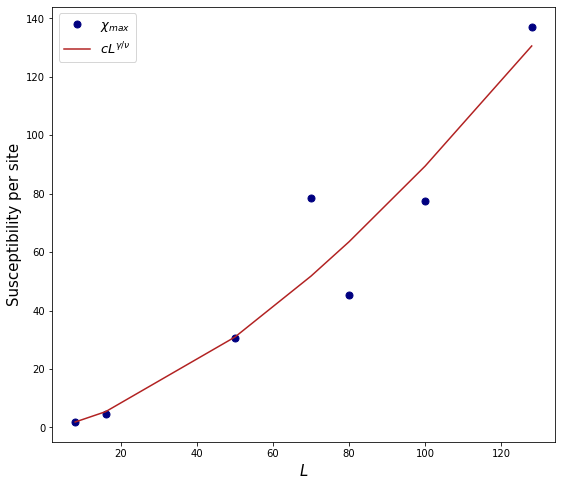

In [28]:
def chi_fit(L,c,z):
    Chi_max = c*(L**z)
    return Chi_max
Chi_site = Chi_max/(L_tot**2)
 
guess = [int(1e2),1.7]
par_chi, cov_chi = curve_fit(chi_fit,L_tot,Chi_site,guess,maxfev=int(1e6))
z = par_chi[1]

gamma_est = z*nu 

print("Estimated exponent gamma = {0:1.5f}".format(gamma_est))

fig, ax = plt.subplots(figsize=(9,8))
ax.set_xlabel("$L$",fontsize=15)
ax.set_ylabel("Susceptibility per site",fontsize=15)
ax.plot(L_tot,Chi_site,'o',color="navy",markersize=7,label="$\chi_{max}$")
ax.plot(L_tot,chi_fit(L_tot,par_chi[0],par_chi[1]), color="firebrick", label="$cL^{{\gamma}/{\\nu}}$")
ax.legend(loc="best", fontsize=13)


The results obtained for $\gamma$ and $\nu$ are not exacly coincident with the real values; this might be caused by the phenomenon known as critical slowing-down.   
Critical slowing down is caused by the divergence of the correlation lenght near the critical temperature $T_c$. Due to this divergence there are correlated fluctuations on larger and larger scale and the time it takes for the system to reach its equilibrium state becomes longer and longer (along with the time needed to compute reliable values for the measured quantities).    

The fluctuations occurring around the critical temperature make it difficult for the Monte Carlo algorithm to explore the configuration space efficiently, since it is a local algorithm.    
A possible way to reduce the effects of the critical slowing down could be that of using the "clustering" technique, which aims to reduce the locality of the MC algorithm: in the clustering technique, the lattice is divided into sub-lattices (clusters) and the Metropolis-Hastings algorithm is applied to each cluster in one Monte-Carlo step, treating the whole as a single spin.    

This procedure would effectively reduce the number of degrees of freedom in the system, and speed up the relaxation time, reducing the autocorrelation of the data (which quantifies the temporal correlation of fluctuations in the system) and leading to more reliable estimates of the physical observables.    
However, there is a trade-off between reducing the autocorrelation time and increasing the computational cost of the simulation, as updating larger clusters with each Monte Carlo step would require more computational resources.

# CONCLUSIONS

In this project, we managed to:
- Simulate the dynamics of the 2D Ising model undergoing a second order phase transition, through the Metropolis-Hastings algorithm;
- Estimate the critical exponents $\gamma$ and $\beta$ through a non-linear fit;
- Estimate the critical exponents $\nu$ and $\gamma$, and the critical temperature $T_c$ through the Finite-size-scaling technique.

Possible improvements to our work could be:
- Estimating the error associated with our simulated data, by keeping track of the variance of the computed quantities during the simulation;
- Estimating the autocorrelation time of the system;
- Addressing the critical slowing down problem by implementing an algorithm based on the clustering technique.

